<br>
<font>
<div dir=ltr align=center>
<img src="https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png" width=150 height=150> <br>
<font color=0F5298 size=7>
    Machine learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2024<br>
<font color=3C99D size=5>
    Practical Assignment 5 - NLP - Skip-Gram <br>
<font color=0CBCDF size=4>
   &#x1F335; Amirhossein Akbari  &#x1F335;
</div>

____



```
# This is formatted as code
```

<font color=9999FF size=4>
&#x1F388; Full Name :mobina kochaknia
<br>
<font color=9999FF size=4>
&#x1F388; Student Number :401106396

<font color=0080FF size=3>
This notebook explores word embeddings, compact and dense vector representations of words that capture their textual meaning. This notebook focusing on implementing the Word2Vec algorithm using the Skip-gram architecture and negative sampling.
</font>
<br>

**Note:**
<br>
<font color=66B2FF size=2>In this notebook, you are free to use any function or model from TensorFlow to assist with the implementation. However, PyTorch is not permitted for this exercise. This ensures consistency and alignment with the tools being focused on.</font>
<br>
<font color=red size=3>**Run All Cells Before Submission**</font>: <font color=FF99CC size=2>Before saving and submitting your notebook, please ensure you run all cells from start to finish. This practice guarantees that your notebook is self-consistent and can be evaluated correctly by others.</font>

<font color=#ffb578 size=3>
you are free to modify, add, or remove any cells as you see fit to complete your tasks. Feel free to change any of the provided code or content to better suit your understanding and approach to the problems.

- **Questions**: If you have any questions or require clarifications as you work through the notebook, please do not hesitate to ask. You can post your queries on Quera or reach out via Telegram.
- **Feedback**: We encourage you to seek feedback and engage in discussions to enhance your learning experience and improve your solutions.
</font>

In [1]:
import io
import math
import gzip
import nltk
import time
import random
import re
import numpy as np
import tensorflow as tf
import gensim.downloader as api
import tensorflow_datasets as tfds
nltk.download('stopwords')

from collections import Counter
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import skipgrams


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Downloading Dataset
We're going to use text8 dataset. Text8 is first 100,000,000 bytes of plain text from Wikipedia. It's mainly used for testing purposes.

In [2]:
def load_data():
  text8_zip_file_path = api.load('text8', return_path=True)
  with gzip.open(text8_zip_file_path, 'rb') as file:
    file_content = file.read()
  wiki = file_content.decode()
  return wiki

wiki = load_data()

### Preprocessing data

**Stopwords removal** - Begin by removing stopwords from the dataset, as they provide little to no value in learning word embeddings. Ensure your preprocessing pipeline filters out commonly used words such as "the," "and," or "of" that do not contribute to meaningful semantic relationships.

---

**Subsampling words** - In a large corpora, most frequent words can easily occur hundreds of millions of times and such words usually don't bring much information to the table.  It is of essential importance to cut down on their frequencies to mitigate the negative impact it adds. For example, co-occurrences of "English" and "Spanish" benefit much more than co-occurrences of "English" and "the" or "Spanish" and "of". To counter the imbalance between rare and frequent words Mikolov et. al came up with the following heuristic formula for determining probability to drop a particular word:

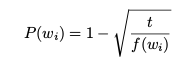

where t is threshold value (heuristically set to 1e-5) and f(w) is frequency of the word.

Implement a subsampling mechanism to handle overly frequent words in the corpus. Use the heuristic formula provided by Mikolov et al. to calculate the probability of dropping a word based on its frequency. This step ensures the corpus maintains a balance between rare and frequent words, improving the quality of word co-occurrence relationships.

---

**Filtering words** - Filter out words that occur only once in the dataset, as they lack sufficient context to be represented effectively. Retain only those words that appear at least five times in the corpus to minimize noise and enhance the overall quality of the embeddings.


In [3]:
def preprocess_text(text):
    """
    Preprocesses the input text by performing standardization, stopword removal,
    frequency-based filtering, and subsampling of overly frequent words.
    """
    # Step 1: Replace punctuation with tokens to standardize the text
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.replace('\n', ' ')  # Replace newlines with spaces

    # Step 2: Convert text to lowercase and remove unnecessary whitespaces
    text = text.lower().strip()

    # Step 3: Remove stopwords
    stopwords = set([
        "the", "and", "of", "in", "to", "a", "is", "that", "it", "on", "for", "with",
        "as", "was", "at", "by", "an", "be", "this", "which", "or", "from", "but",
        "not", "are", "have", "has", "had", "were", "will", "would", "should"
    ])
    tokens = text.split()
    filtered_tokens = [word for word in tokens if word not in stopwords]

    # Step 4: Remove words with frequency less than 5
    word_counts = Counter(filtered_tokens)
    filtered_tokens = [word for word in filtered_tokens if word_counts[word] >= 5]

    # Step 5: Subsample words using a threshold value
    def subsample(word, frequency, total_count, threshold=1e-5):
        """Determines whether a word should be included based on its frequency."""
        f_w = frequency / total_count
        probability = 1 - np.sqrt(threshold / f_w)
        return np.random.rand() > probability

    total_word_count = sum(word_counts.values())
    final_tokens = [
        word for word in filtered_tokens
        if subsample(word, word_counts[word], total_word_count)
    ]

    return final_tokens, word_counts


It's always a good idea to take a quick look at preprocessed sample before heading further - you might observe few things that if handled can enrich or correct your data. More like a validation step this.

In [4]:
# Take a quick look at a slice of preprocessed words (e.g., index 1500 to 1550)

processed_tokens, word_counts = preprocess_text(wiki)

# Inspect a slice of preprocessed tokens
sample_start, sample_end = 1500, 1550
preprocessed_sample = processed_tokens[sample_start:sample_end]

# Display the sample
print(f"Sample of preprocessed words ({sample_start} to {sample_end}):")
print(preprocessed_sample)


Sample of preprocessed words (1500 to 1550):
['criticisms', 'violence', 'violence', 'too', 'violent', 'engels', 'enough', 'authoritarian', 'whereby', 'imposes', 'bayonets', 'authoritarian', 'party', 'want', 'fought', 'vain', 'terror', 'arms', 'inspire', 'paris', 'commune', 'lasted', 'armed', 'bourgeois', 'utopianism', 'anarchism', 'criticised', 'utopian', 'agree', 'nice', 'carl', 'criticizes', 'unrealistically', 'utopian', 'lesser', 'society', 'without', 'repressive', 'holds', 'intentions', 'cease', 'repressive', 'disappears', 'absurdity', 'however', 'noted', 'anarchists', 'utopian', 'benjamin', 'advocate']


### Hyperparameters
Setting a few hyperparamters required for gnerating batches and for deciding the size of word embeddings.



In [5]:
# Hyperparameters
WINDOW_SIZE = 2
NEGATIVE_SAMPLES = 2
BUFFER_SIZE = 10000
BATCH_SIZE = 128

### Preparing TensorFlow Dataset using Skipgrams

**Generating Skipgrams**

Tokenize your preprocessed textual data and convert the words into their corresponding vectorized tokens. Then, use the `skipgrams` function provided by Keras to generate (word, context) pairs. Ensure the following steps are completed:

- Generate positive samples: (word, word in the same window), with label 1.  
- Generate negative samples: (word, random word from the vocabulary), with label 0.  

Refer to Mikolov et al.'s paper, [Efficient Estimation of Word Representations in Vector Space](https://arxiv.org/pdf/1301.3781v3.pdf), for more details on Skipgrams.

---

**Negative Sampling**

For each input word, implement the negative sampling approach to optimize the training process. Transform the problem of predicting context words into independent binary classification tasks. For every (target, context) pair, generate random negative (target, ~context) samples. This step will reduce computational complexity and make training more efficient.


In [10]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import skipgrams
from sklearn.model_selection import train_test_split

# Hyperparameters
WINDOW_SIZE = 2
NEGATIVE_SAMPLES = 2
BUFFER_SIZE = 10000
TARGET_BATCHES_TRAIN = 21445  # Target number of batches for training
TARGET_BATCHES_TEST = 2382   # Target number of batches for testing
TARGET_SAMPLES_TRAIN = TARGET_BATCHES_TRAIN * 128  # Assuming batch size of 128
TARGET_SAMPLES_TEST = TARGET_BATCHES_TEST * 128


# Step 1: Initialize and fit the tokenizer on preprocessed words
def initialize_tokenizer(preprocessed_words):
    """Creates and fits a tokenizer on the preprocessed words."""
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(preprocessed_words)
    return tokenizer

# Assuming `processed_tokens` is your preprocessed data
tokenizer = initialize_tokenizer(processed_tokens)
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1  # Including padding index

# Step 2: Vectorize the words using the tokenizer's word index
vectorized_tokens = tokenizer.texts_to_sequences([processed_tokens])[0]

# Step 3: Generate skipgram pairs and labels
def generate_skipgram_pairs(tokens, vocab_size, window_size, negative_samples):
    """Generates skipgram pairs with labels."""
    skipgram_pairs, skipgram_labels = skipgrams(
        sequence=tokens,
        vocabulary_size=vocab_size,
        window_size=window_size,
        negative_samples=negative_samples
    )
    targets = np.array([pair[0] for pair in skipgram_pairs], dtype=np.int32)
    contexts = np.array([pair[1] for pair in skipgram_pairs], dtype=np.int32)
    labels = np.array(skipgram_labels, dtype=np.int32)
    return targets, contexts, labels

# Generate skipgram pairs and labels
targets, contexts, labels = generate_skipgram_pairs(
    tokens=vectorized_tokens,
    vocab_size=vocab_size,
    window_size=WINDOW_SIZE,
    negative_samples=NEGATIVE_SAMPLES
)

# Step 4: Extract target and context words from the generated pairs
# This is done during the `generate_skipgram_pairs` function

# Step 5: Split the data into training and testing sets
X = np.column_stack((targets, contexts))  # Combine targets and contexts into one array
y = labels

# Reduce dataset size to target number of samples
total_samples = TARGET_SAMPLES_TRAIN + TARGET_SAMPLES_TEST
X = X[:total_samples]
y = y[:total_samples]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TARGET_SAMPLES_TEST / total_samples, random_state=42
)

# Step 6: Create TensorFlow datasets
def create_tf_dataset(X, y, batch_size):
    """Creates a TensorFlow dataset from the input and labels."""
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    dataset = dataset.shuffle(BUFFER_SIZE).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

train_dataset = create_tf_dataset(X_train, y_train, BATCH_SIZE)
test_dataset = create_tf_dataset(X_test, y_test, BATCH_SIZE)

# Count the number of batches
num_train_batches = sum(1 for _ in train_dataset)
num_test_batches = sum(1 for _ in test_dataset)

# Print results
print(f"Number of batches in the training dataset: {num_train_batches}")
print(f"Number of batches in the testing dataset: {num_test_batches}")


Number of batches in the training dataset: 21445
Number of batches in the testing dataset: 2382


### Building the Model

Use the model subclassing method to build your model. While Sequential and Functional APIs are generally more suitable for most use cases, model subclassing allows you to create the model in an object-oriented way. Follow these steps:

1. Define a custom model class by inheriting from `tf.keras.Model`.
2. Implement the `__init__` method to define the layers of your model.
3. Override the `call` method to define the forward pass of your model.
4. Ensure that the model includes embedding layers, a skip-gram architecture, and any other necessary components for training.


In [11]:
import tensorflow as tf

# Step 1: Create a custom model class by subclassing `tf.keras.Model`
class SkipGramModel(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim):
        """
        Initialize the Skip-gram model with embedding and dense layers.

        Args:
            vocab_size (int): Size of the vocabulary.
            embedding_dim (int): Dimension of the embedding vectors.
        """
        super(SkipGramModel, self).__init__()

        # Initialize layers
        self.embedding = tf.keras.layers.Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            name="embedding_layer"
        )
        self.context_embedding = tf.keras.layers.Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            name="context_embedding_layer"
        )
        self.dot_product = tf.keras.layers.Dot(axes=-1, name="dot_product_layer")

    def call(self, inputs):
        """
        Forward pass of the model.

        Args:
            inputs (tuple): A tuple containing (center_word, context_word).

        Returns:
            Tensor: Dot product of embeddings for center and context words.
        """
        center_word, context_word = inputs  # Unpack inputs
        center_emb = self.embedding(center_word)  # Get embeddings for center word
        context_emb = self.context_embedding(context_word)  # Get embeddings for context word
        similarity = self.dot_product([center_emb, context_emb])  # Compute dot product
        return similarity


# Function to ensure all word indices are within the valid range
def clip_indices(dataset, vocab_size):
    """Clips the indices in the dataset to be within [0, vocab_size-1]."""
    def clip_fn(x, y):
        x_clipped = tf.clip_by_value(x, 0, vocab_size - 1)  # Clip input indices
        return x_clipped, y
    return dataset.map(clip_fn)


# Define hyperparameters
vocab_size = 5000  # Adjust based on your dataset
embedding_dim = 128  # Size of word embeddings

# Assuming train_dataset and test_dataset are already prepared
# Clip indices to ensure they are within the valid range
train_dataset = clip_indices(train_dataset, vocab_size)
test_dataset = clip_indices(test_dataset, vocab_size)

# Initialize the Skip-gram model
model = SkipGramModel(vocab_size, embedding_dim)

# Verify with train_dataset
print("Testing Skip-gram model with data from train_dataset...")
for (X_batch, y_batch) in train_dataset.take(1):  # Take one batch from train_dataset
    center_words = X_batch[:, 0]  # Extract center words from X_batch
    context_words = X_batch[:, 1]  # Extract context words from X_batch
    output = model((center_words, context_words))  # Forward pass through the model

    # Print results for training batch
    print("\nTraining Batch Verification:")
    print("Center words (first 10):", center_words.numpy()[:10])
    print("Context words (first 10):", context_words.numpy()[:10])
    print("Output shape:", output.shape)
    print("Similarity scores (first 10):", output.numpy()[:10])
    break

# Verify with test_dataset
print("\nTesting Skip-gram model with data from test_dataset...")
for (X_batch, y_batch) in test_dataset.take(1):  # Take one batch from test_dataset
    center_words = X_batch[:, 0]  # Extract center words from X_batch
    context_words = X_batch[:, 1]  # Extract context words from X_batch
    output = model((center_words, context_words))  # Forward pass through the model

    # Print results for testing batch
    print("\nTesting Batch Verification:")
    print("Center words (first 10):", center_words.numpy()[:10])
    print("Context words (first 10):", context_words.numpy()[:10])
    print("Output shape:", output.shape)
    print("Similarity scores (first 10):", output.numpy()[:10])
    break


Testing Skip-gram model with data from train_dataset...

Training Batch Verification:
Center words (first 10): [ 297 3096 2292 2171 4999 4999 1070 4999 4999 4999]
Context words (first 10): [4999 4999 4999 4999 4999 4999 4999 4999  419 4999]
Output shape: (128, 1)
Similarity scores (first 10): [[-0.00067044]
 [ 0.02168925]
 [-0.0013479 ]
 [-0.00993794]
 [-0.00275239]
 [-0.00275239]
 [ 0.00881317]
 [-0.00275239]
 [ 0.00780712]
 [-0.00275239]]

Testing Skip-gram model with data from test_dataset...

Testing Batch Verification:
Center words (first 10): [4152  678 4999 4999  597 4934 4999 4999 2130  455]
Context words (first 10): [4999 4999 4999 4999 4999 4999 4999 4999 4999 4999]
Output shape: (128, 1)
Similarity scores (first 10): [[-0.00107036]
 [ 0.01282146]
 [-0.00275239]
 [-0.00275239]
 [ 0.01034026]
 [ 0.00341335]
 [-0.00275239]
 [-0.00275239]
 [-0.00319588]
 [ 0.0008168 ]]


### Loss function, Metrics and Optimizers

In [12]:
# Define optimizer, loss function, and metrics
optimiser = tf.keras.optimizers.Adam(learning_rate=0.001)  # Adam optimizer for efficient training
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)  # Binary cross-entropy for skip-gram architecture
train_acc_metric = tf.keras.metrics.BinaryAccuracy(name="train_accuracy")  # Accuracy metric for training
val_acc_metric = tf.keras.metrics.BinaryAccuracy(name="val_accuracy")  # Accuracy metric for validation


### Training the Model

Implement custom training for learning word embeddings to gain finer control over optimization and training tasks. Follow these steps:

1. Define a custom training loop that includes forward propagation, loss computation, and backpropagation.
2. Use the optimizer of your choice to update the model's weights based on the computed gradients.
3. Implement batching for efficient data processing during training.
4. Monitor the loss during each epoch to track the model's performance.
5. Save the trained embeddings for later use once the training is complete.

In [13]:
import tensorflow as tf
import numpy as np
import time

# Define hyperparameters
vocab_size = 5000
embedding_dim = 128
epochs = 5
batch_size = 128
learning_rate = 0.001

# Step 1: Define the training step
@tf.function
def train_step(center_words, context_words, labels, model, optimizer, loss_fn, train_acc_metric):
    """
    Perform a single training step.
    """
    with tf.GradientTape() as tape:
        predictions = model((center_words, context_words))
        loss = loss_fn(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))
    train_acc_metric.update_state(labels, predictions)
    return loss

# Step 2: Define the testing step
@tf.function
def test_step(center_words, context_words, labels, model, loss_fn, val_acc_metric):
    """
    Perform a single validation step.
    """
    predictions = model((center_words, context_words))
    loss = loss_fn(labels, predictions)
    val_acc_metric.update_state(labels, predictions)
    return loss

# Initialize the model, optimizer, loss function, and metrics
model = SkipGramModel(vocab_size, embedding_dim)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
train_acc_metric = tf.keras.metrics.BinaryAccuracy(name="train_accuracy")
val_acc_metric = tf.keras.metrics.BinaryAccuracy(name="val_accuracy")

# Step 3: Initialize the training loop
for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    epoch_start_time = time.time()
    train_acc_metric.reset_state()
    val_acc_metric.reset_state()
    total_train_loss = 0.0
    total_val_loss = 0.0

    # Step 4: Perform training on each batch
    for step, (X_batch, y_batch) in enumerate(train_dataset):
        center_words = X_batch[:, 0]
        context_words = X_batch[:, 1]
        loss = train_step(center_words, context_words, y_batch, model, optimizer, loss_fn, train_acc_metric)
        total_train_loss += loss.numpy()

        # Log training progress every 100 steps
        if step % 100 == 0:
            print(f"Step {step}: Train Loss = {loss.numpy():.4f}")

    # Step 5: Compute and display training accuracy
    train_accuracy = train_acc_metric.result().numpy()
    avg_train_loss = total_train_loss / (step + 1)
    print(f"Epoch {epoch + 1} - Train Loss: {avg_train_loss:.4f} - Train Accuracy: {train_accuracy:.4f}")

    # Step 6: Perform validation on the test dataset
    for step, (X_batch, y_batch) in enumerate(test_dataset):
        center_words = X_batch[:, 0]
        context_words = X_batch[:, 1]
        val_loss = test_step(center_words, context_words, y_batch, model, loss_fn, val_acc_metric)
        total_val_loss += val_loss.numpy()

    # Step 7: Log validation metrics
    val_accuracy = val_acc_metric.result().numpy()
    avg_val_loss = total_val_loss / (step + 1)
    print(f"Epoch {epoch + 1} - Val Loss: {avg_val_loss:.4f} - Val Accuracy: {val_accuracy:.4f}")

    # Step 8: Track time per epoch
    epoch_end_time = time.time()
    print(f"Time taken for epoch {epoch + 1}: {epoch_end_time - epoch_start_time:.2f} seconds")

# Save the trained embeddings
trained_embeddings = model.embedding.get_weights()[0]
context_embeddings = model.context_embedding.get_weights()[0]
np.save("trained_embeddings.npy", trained_embeddings)
np.save("context_embeddings.npy", context_embeddings)
print("Trained embeddings saved.")



Epoch 1/5
Step 0: Train Loss = 0.6917
Step 100: Train Loss = 0.6611
Step 200: Train Loss = 0.6008
Step 300: Train Loss = 0.5749
Step 400: Train Loss = 0.5865
Step 500: Train Loss = 0.5809
Step 600: Train Loss = 0.6055
Step 700: Train Loss = 0.5701
Step 800: Train Loss = 0.6095
Step 900: Train Loss = 0.5405
Step 1000: Train Loss = 0.6573
Step 1100: Train Loss = 0.5745
Step 1200: Train Loss = 0.5970
Step 1300: Train Loss = 0.5491
Step 1400: Train Loss = 0.5844
Step 1500: Train Loss = 0.4916
Step 1600: Train Loss = 0.4985
Step 1700: Train Loss = 0.5322
Step 1800: Train Loss = 0.5583
Step 1900: Train Loss = 0.6166
Step 2000: Train Loss = 0.5428
Step 2100: Train Loss = 0.5308
Step 2200: Train Loss = 0.6154
Step 2300: Train Loss = 0.6085
Step 2400: Train Loss = 0.4640
Step 2500: Train Loss = 0.5522
Step 2600: Train Loss = 0.5063
Step 2700: Train Loss = 0.5722
Step 2800: Train Loss = 0.4906
Step 2900: Train Loss = 0.5458
Step 3000: Train Loss = 0.5408
Step 3100: Train Loss = 0.5315
Step 3200

### Word Embeddings Projector

Follow these steps to visualize the learned word embeddings using TensorFlow's Embedding Projector:

1. Extract the weights of the embedding layer from your trained model.
2. Save the weights into two files:
   - `vecs.tsv`: This file will store the actual vector representations of words.
   - `meta.tsv`: This file will store the associated metadata (e.g., word labels) for visualization.
3. Go to [TensorFlow Embedding Projector](http://projector.tensorflow.org/).
4. Upload the `vecs.tsv` and `meta.tsv` files created in the previous step.
5. Explore the visualizations provided by TensorFlow's Embedding Projector.
<font color=#ffb578>
6.Save the visualization of a word that best demonstrate the quality of your embeddings as an image and store it near the notebook.
7. Compress the folder into a `.zip` file and submit it as part of your work.

</font>


In [14]:
import os
import numpy as np


output_dir = "embedding_projector"
os.makedirs(output_dir, exist_ok=True)

# Step 1: Access the embedding layer from the trained model
embedding_layer = model.embedding

# Step 2: Extract the weights from the embedding layer
embedding_weights = embedding_layer.get_weights()[0]  # Shape: (vocab_size, embedding_dim)

# Step 3: Open files to store embeddings and metadata
vecs_file = os.path.join(output_dir, "vecs.tsv")
meta_file = os.path.join(output_dir, "meta.tsv")

with open(vecs_file, 'w', encoding='utf-8') as vecs, open(meta_file, 'w', encoding='utf-8') as meta:
    # Step 4: Iterate through the tokenizer's vocabulary
    for word, idx in tokenizer.word_index.items():
        if idx < vocab_size:  # Ensure index is within vocab_size
            embedding_vector = embedding_weights[idx]
            vecs.write('\t'.join([str(x) for x in embedding_vector]) + '\n')  # Write vector
            meta.write(word + '\n')  # Write word (metadata)

# Step 5: Ensure the files are properly saved and closed
print(f"Embeddings saved to {vecs_file}")
print(f"Metadata saved to {meta_file}")


Embeddings saved to embedding_projector/vecs.tsv
Metadata saved to embedding_projector/meta.tsv
